In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
# Generate syntectic data for house prices
np.random.seed(42)
num_samples = 500

# Features: house size (sq ft) and location index
X = np.random.rand(num_samples, 2) *100

# True price equation: Price = 50 * size + 30 * Location + Noise
y = 50 * X[:, 0] + 30 * X[:, 1] + np.random.randn(num_samples) *10
y = y.reshape(-1, 1)

# Split into training and test sets
train_size = int(0.8 * num_samples)
X_train, y_train = X[: train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print(f"Training Samples: {X_train.shape}, Test Samples: {X_test.shape}")

Training Samples: (400, 2), Test Samples: (100, 2)


In [4]:
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, rank=2, alpha=1.0):
        super(LoRALayer, self).__init__()
        self.rank = rank
        self.alpha = alpha # Scaling factor

        # Main frozen weight matrix
        self.W = self.add_weight(shape=(input_dim, output_dim), initializer="random_normal", trainable=False)

        # LoRA trainable low-rank matrices
        self.A = self.add_weight(shape=(input_dim, rank), initializer="random_normal", trainable=True)
        self.B = self.add_weight(shape=(rank, output_dim), initializer="random_normal", trainable=True)

    def call(self, inputs):
        lora_update = tf.matmul(inputs, self.A) # XA
        lora_update = tf.matmul(lora_update, self.B) * self.alpha # XAB alpha
        return tf.matmul(inputs, self.W) + lora_update # W is frozen, only A and B update

        # XW + XAB alpha
        # X (W + AB alpha)
    
        

In [5]:
# Define the model with LoRA
input_dim = X_train.shape[1]
output_dim = 1 # Predicting house price

inputs = keras.Input(shape=(input_dim,))
x = LoRALayer(input_dim, 16, rank=2, alpha=1.0)(inputs) # LoRA applied here
x = layers.ReLU()(x)
x = layers.Dense(1)(x) # Final regression output
model = keras.Model(inputs, x)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")


In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18399526.0000 - val_loss: 16003237.0000
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17205704.0000 - val_loss: 13604535.0000
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11781983.0000 - val_loss: 5969108.0000
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2530671.0000 - val_loss: 180198.0469
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 242434.7188 - val_loss: 132257.4844
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115485.4766 - val_loss: 92667.2891
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76712.1719 - val_loss: 61642.4219
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51844.4805 - val_loss: 40744.8711
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33527.2695 - val_loss: 25910.8496
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21222.9453 - val_loss: 15662.2988


Test Loss (MSE): 15662.298828125


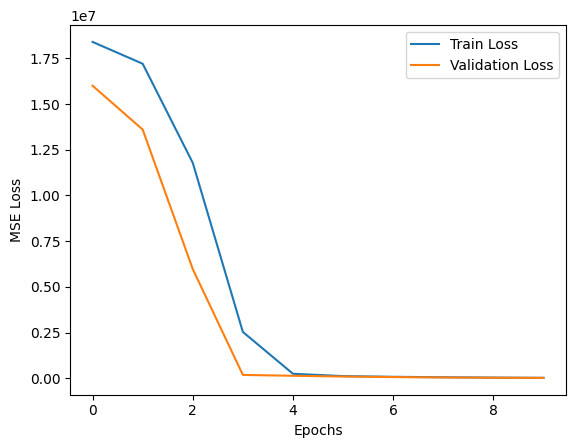

In [7]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

# Plot training loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [ ]:
# 🔹 Step 2: 4-bit Quantization Function
def quantize_4bit(weights):
    """Convert weights to 4-bit representation and store scale factor."""
    min_w, max_w = np.min(weights), np.max(weights)
    scale = (max_w - min_w) / 15  # 2^4 - 1 = 15 levels in 4-bit
    quantized = np.round((weights - min_w) / scale).astype(np.int8)  # Store as int8
    return quantized, min_w, scale

def dequantize_4bit(quantized, min_w, scale):
    """Dequantize 4-bit weights back to floating point values."""
    return quantized * scale + min_w

